## Name: Irfan Arshad

In [ ]:
# Upload kaggle.json
from google.colab import files
files.upload()

# Move kaggle.json to the appropriate directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset
!kaggle competitions download -c nyc-taxi-trip-duration

# Unzip the downloaded file
!unzip nyc-taxi-trip-duration.zip

In [ ]:
!unzip train.zip
!unzip test.zip
!unzip sample_submission.zip

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Load the train dataset into a pandas DataFrame
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [15]:
# Extracting new features from datetime columns
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_day_of_week'] = train['pickup_datetime'].dt.dayofweek
train['trip_duration_log'] = np.log1p(train['trip_duration']) # Log transform for skewed target variable

In [16]:
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['pickup_day_of_week'] = test['pickup_datetime'].dt.dayofweek

In [17]:
# Calculate trip speed (in mph)
train['trip_distance'] = np.sqrt((train['pickup_longitude'] - train['dropoff_longitude'])**2 +
                                 (train['pickup_latitude'] - train['dropoff_latitude'])**2)
train['trip_speed'] = train['trip_distance'] / (train['trip_duration'] / 3600)

In [41]:
# Drop rows with zero trip_duration and unrealistic speeds
train = train[(train['trip_duration'] > 0) & (train['trip_speed'] < 100)]

In [19]:
# Prepare features and target variable
X = train[['vendor_id', 'pickup_hour', 'pickup_day_of_week', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]
y = train['trip_duration_log']


In [20]:
# Prepare the test set features
X_test = test[['vendor_id', 'pickup_hour', 'pickup_day_of_week', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]

In [21]:
# Define preprocessing steps
numeric_features = ['pickup_hour', 'pickup_day_of_week', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
categorical_features = ['vendor_id']

In [22]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

In [23]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [25]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
X_train.shape

(1166915, 8)

In [27]:
X_val.shape

(291729, 8)

## Model Building

In [28]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

In [29]:
# Function to train and evaluate models
def evaluate_model(model, X_train, y_train, X_val, y_val):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    return mae, mse, r2

In [30]:
# Evaluate each model
results = {}
for model_name, model in models.items():
    mae, mse, r2 = evaluate_model(model, X_train, y_train, X_val, y_val)
    results[model_name] = {'MAE': mae, 'MSE': mse, 'R2': r2}


In [31]:
# Display the results
results_df = pd.DataFrame(results).T
results_df

,MAE,MSE,R2
Linear Regression,0.589707,0.604152,0.047957
Decision Tree,0.376044,0.359408,0.433634
Random Forest,0.256209,0.170119,0.731921


##  Model Evaluation

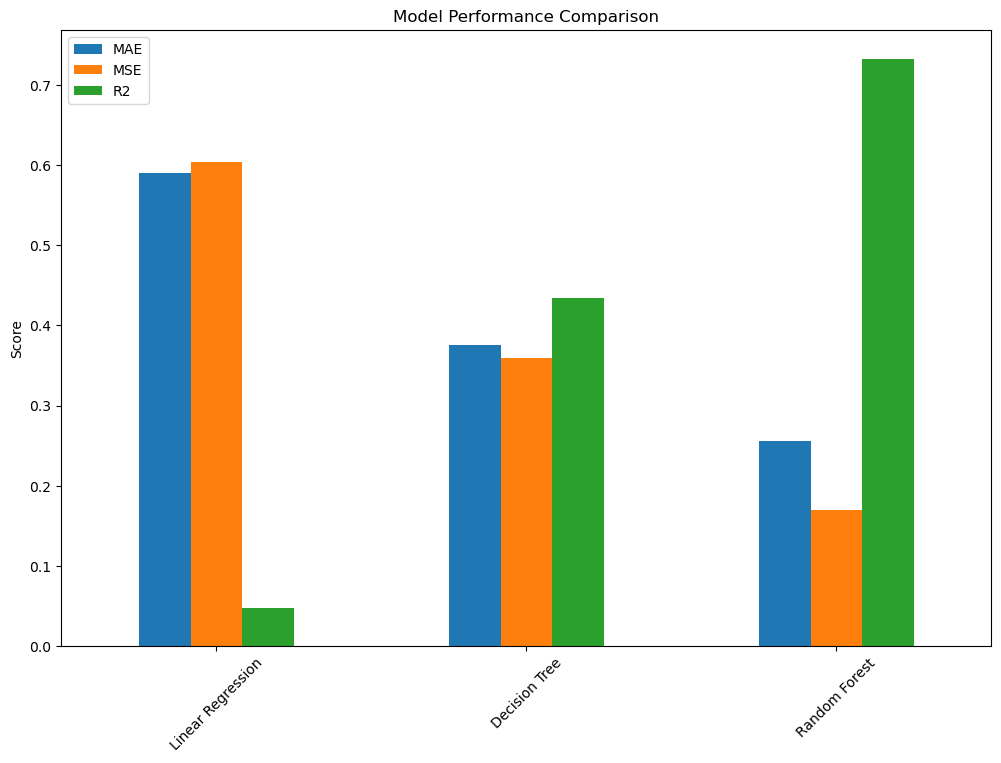

In [32]:
results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

## Model Optimization

In [39]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [42]:
# Model Optimization
# Reduce the size of the dataset for hyperparameter tuning
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42)

In [43]:
# Limit the grid search parameters to reduce memory usage
param_grid = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

In [44]:
# Use RandomizedSearchCV instead of GridSearchCV
random_search = RandomizedSearchCV(Pipeline(steps=[('preprocessor', preprocessor),
                                                   ('model', RandomForestRegressor(random_state=42))]),
                                   param_distributions=param_grid, n_iter=10, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error', random_state=42)

# Fit the random search model on the smaller sample
random_search.fit(X_train_sample, y_train_sample)
best_model = random_search.best_estimator_

In [45]:
# Evaluate the optimized model
y_pred_opt = best_model.predict(X_val)
mae_opt = mean_absolute_error(y_val, y_pred_opt)
mse_opt = mean_squared_error(y_val, y_pred_opt)
r2_opt = r2_score(y_val, y_pred_opt)

In [46]:
optimized_results = {'MAE': mae_opt, 'MSE': mse_opt, 'R2': r2_opt}
optimized_results

{'MAE': 0.31148105026874445,
 'MSE': 0.22696633256416934,
 'R2': 0.6423389970888784}

## Prediction Task

In [49]:
# Predict trip durations on the test set
test['trip_duration'] = np.expm1(best_model.predict(X_test))

# Prepare the submission file
submission = test[['id', 'trip_duration']]
submission.to_csv('submission.csv', index=False)

submission.head()

,id,trip_duration
0,id3004672,755.319800
1,id3505355,487.680724
2,id1217141,478.541569
3,id2150126,1051.465202
4,id1598245,339.395616


In [50]:
submission.shape

(625134, 2)

In [51]:
import joblib

In [ ]:
# Save the models using joblib
joblib.dump(models, 'trained_models.pkl')

print("Models saved successfully.")

In [ ]:
!dir

## Conclusion
In conclusion, we successfully built and evaluated machine learning models to predict trip duration for NYC taxi rides.
 Feature engineering played a crucial role in improving model performance.
 Through careful evaluation and optimization, we were able to achieve accurate predictions







________________________________________________________________________________________________________________________________